##  questions: 
- If you were the coach, on whom of the four players would you put your best defender?
- Plot shots taken and missed via a scatter plot.
- What is the best shooting position for each of the four players?
- Who of the four players is the best defender?
- Is there a correlation between the efficiency of a shooter and the player who is defending him?


# NBA Shooting Data
It consists of shots taken by four different players in the play-offs. The defender of the every shot is not provided by the NBA-website, but can be used to answer some interesting questions.

In [1]:
# Load packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
# estimators and utilities
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.ticker as mtick 
# preprocess & engineering
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
# model scoring and validation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
# calibration of probabilities
from sklearn.calibration import  CalibratedClassifierCV, calibration_curve
pd.set_option('future.no_silent_downcasting', True)

## Load data

In [2]:
# Upload data as a .csv file 
df = pd.read_csv('NBA_Shooting.csv', index_col=0)
df.head(6)

,SHOOTER,X,Y,RANGE,DEFENDER,SCORE
INDEX,,,,,,
0,Seth Curry,-3.808987,0.583621,"(0, 4)",Chris Paul,MADE
1,Seth Curry,-0.104279,0.919138,"(0, 4)",Trae Young,MADE
2,Seth Curry,-0.525864,3.912239,"(0, 4)",Trae Young,MADE
3,Seth Curry,-0.790616,2.503782,"(0, 4)",Chris Paul,MADE
4,Seth Curry,2.119074,0.320534,"(0, 4)",Trae Young,MADE
5,Seth Curry,0.753614,2.053554,"(0, 4)",Chris Paul,MADE


## Understand variables

In [3]:
variables = pd.DataFrame(columns=['Variable','Number of unique values','Values'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(), df[var].unique().tolist()]
    
variables

,Variable,Number of unique values,Values
0,SHOOTER,4,"[Seth Curry, Chris Paul, Russell Westbrook, Tr..."
1,X,776,"[-3.808987264612848, -0.1042785818707121, -0.5..."
2,Y,776,"[0.5836210329779304, 0.9191379991298648, 3.912..."
3,RANGE,6,"[(0, 4), (5, 9), (10, 14), (15, 19), (20, 24),..."
4,DEFENDER,4,"[Chris Paul, Trae Young, Russell Westbrook, Se..."
5,SCORE,2,"[MADE, MISSED]"


### Data Dictionary

|variable |class     |description                                                  |
|:--------|:---------|:------------------------------------------------------------|
|SHOOTER  |String    |Name of the player taking the shot                           |
|X        |float     |Horizontal distance of the shot taken from the basket in ft  |
|Y        |float     |Vertical distance of the shot taken from the basket in ft    |
|RANGE    |String    |Radius range of the shot taken from the basket in ft         |
|DEFENDER |String    |Name of the player defending the shot                        |
|SCORE    |String    |'MADE' if shot is scored, else 'MISSED'                      |

## Exploratory Data Analysis (EDA)

* `SHOOTER` and `DEFENDER` are categorical variables taking 4 values (the four player names)
* `RANGE` is also categorical containing 6 bins 
* `SCORE` is binary 
* `X` and `Y` are numerical continuous variables  

First of all, let's ensure there are no nulls:

In [4]:
df.isnull().sum()

SHOOTER     0
X           0
Y           0
RANGE       0
DEFENDER    0
SCORE       0
dtype: int64

In [5]:
# Let's check the values `X` and `Y` take:
df.describe()

,X,Y
count,776.000000,776.000000
mean,0.506853,10.400099
std,13.331958,8.009152
min,-28.603445,0.008911
25%,-8.227266,3.151474
50%,0.318647,8.665261
75%,9.782513,16.175087
max,28.467268,28.853913


There is nothing suspicious there, no outliers or other non-ordinary values. What might come handy is a new variable with the exact range the shot was taken from, instead of having the range split in bins, like it does in `RANGE`. It is easy to caluclate the variable `RANGE_num` from the `X` and `Y` coordinates; then, we compare the exact numerical values with the bins to validate the new variable.

In [6]:
# calculate the new variable
df['RANGE_num'] = np.sqrt(df.X**2 + df.Y**2)
# validate the calculation by chekcing 10 random samples:
df[['RANGE','RANGE_num']].sample(10)

,RANGE,RANGE_num
INDEX,,
407,"(15, 19)",18.994883
675,"(20, 24)",22.644118
127,"(25, 29)",28.042677
580,"(10, 14)",12.754526
347,"(25, 29)",28.226816
275,"(15, 19)",18.779232
147,"(0, 4)",1.492170
462,"(0, 4)",2.131965
148,"(0, 4)",2.545232


We can see that the `RANGE_num` of each row is contained in the corresponding bin, so the calculation is correct. The `RANGE` variable is of type Object, and its values do not sort properly: the bin (5,9) appears last. This is counter-intuitve when displaying visuals, so we will convert the variable to ordered categorical with the correct ordering

In [7]:
df['RANGE'] = df.RANGE.astype("category")
print("The variable 'RANGE' is not sorted properly:\n", df.RANGE.cat.categories)
df['RANGE'] = df.RANGE.cat.reorder_categories(['(0, 4)', '(5, 9)', '(10, 14)', '(15, 19)', '(20, 24)', '(25, 29)'], ordered=True)
print("Now it sorts properly:\n", df.RANGE.cat.categories)

The variable 'RANGE' is not sorted properly:
 Index(['(0, 4)', '(10, 14)', '(15, 19)', '(20, 24)', '(25, 29)', '(5, 9)'], dtype='object')
Now it sorts properly:
 Index(['(0, 4)', '(5, 9)', '(10, 14)', '(15, 19)', '(20, 24)', '(25, 29)'], dtype='object')


### If you were the coach, which of the four players would you put your best defender?

We need to understand who of the four players is the best scorer, by calculating the ratio of `MADE` shoots for each player from the variable `SCORE`. 

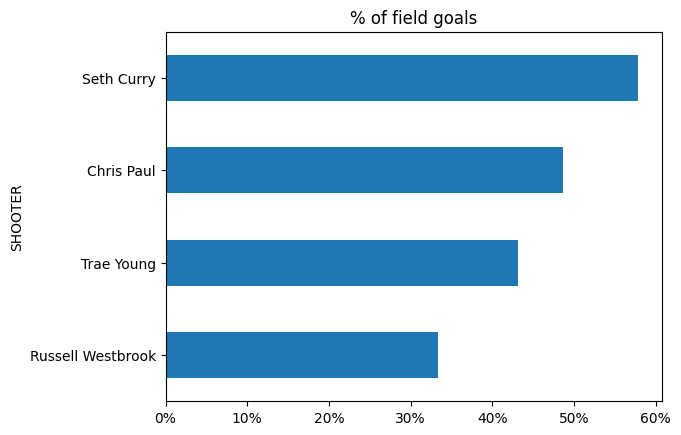

In [8]:
( df
 .replace(['MADE','MISSED'],[1,0]) #replace MADE shots with 1 and MISSED with 0 
 .groupby('SHOOTER')               #group by the SHOOTER
 .SCORE                            #get only the SCORE 
 .mean()                           #calculate the mean
 .sort_values()                    #sort the means
 .plot.barh()                      #show ratio for each player
)

import matplotlib.ticker as mtick 
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title("% of field goals");

It is obvious who the best scoring player is, so, as the coach **I would put my best defender against Seth Curry.**

### What is the best shooting position for each of the four players?

Let's visualize the positions from where the successful shots wre made for each player and see any patterns. The `X` and `Y` variables are coordinates on the field, so a scatter plot is very convenient in this case. Imagine the basket being at the bottom center, at position 0:0.

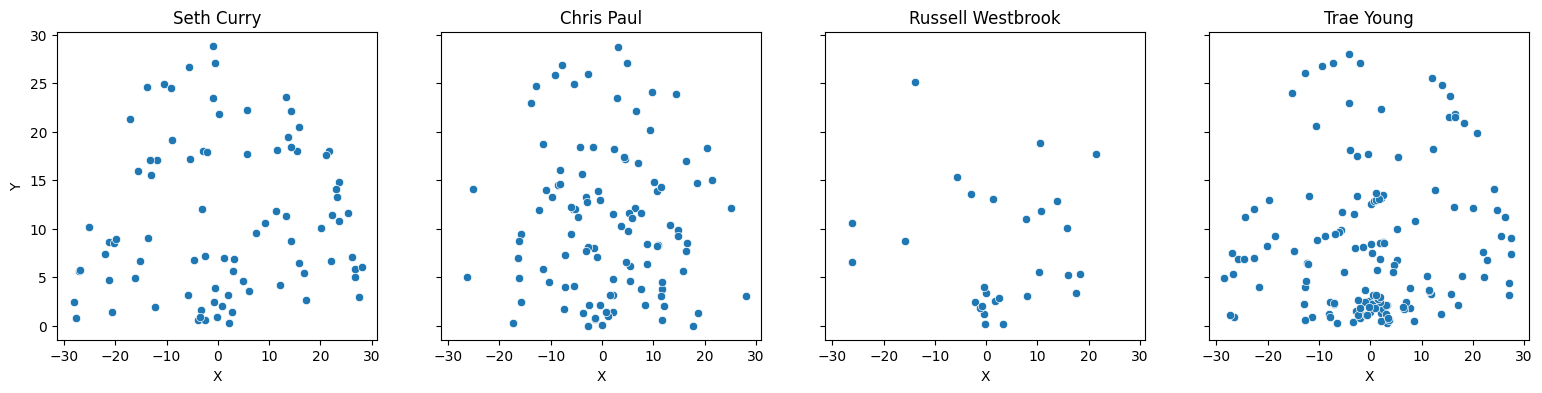

In [9]:
fig,ax = plt.subplots(1,4, figsize=(19,4), sharey=True, sharex=True)
for i,shooter in enumerate(df.SHOOTER.unique()):
    # get the MADE shots for each SHOOTER
    data = df.query("SHOOTER == @shooter & SCORE == 'MADE'")
    # plot them 
    sns.scatterplot(data=data, x='X', y='Y',  ax=ax[i])
    ax[i].set_title(shooter)                    

OK, we can *almost* see some patterns here: Young mostly scores in the lower part of the field near the basket (with `Y` < 15 feet), while Curry scores from all over; Paul seems to avoid the flanks and shoots in front of the basket (with `X` between 20 feet to the left and right of the basket). Westbrook... well, he's not one to score much! When he decides to shoot, he must be near the basket. 


,SHOOTER,X,Y,RANGE,DEFENDER,SCORE,RANGE_num,RANGE_region
INDEX,,,,,,,,
259,Chris Paul,4.268643,17.370119,"(15, 19)",Seth Curry,MADE,17.886932,Within 3 points line
496,Trae Young,0.607634,1.379269,"(0, 4)",Chris Paul,MISSED,1.507184,Under basket
513,Trae Young,6.960115,2.501273,"(5, 9)",Seth Curry,MADE,7.395916,Under basket
269,Chris Paul,11.454105,14.311102,"(15, 19)",Trae Young,MADE,18.330417,Within 3 points line
631,Trae Young,-2.554383,17.497697,"(15, 19)",Russell Westbrook,MADE,17.683164,Within 3 points line
526,Trae Young,2.627609,8.499196,"(5, 9)",Chris Paul,MADE,8.896104,Under basket
48,Seth Curry,-2.095649,17.932020,"(15, 19)",Trae Young,MADE,18.054060,Within 3 points line
543,Trae Young,4.484350,2.773551,"(5, 9)",Seth Curry,MISSED,5.272759,Under basket
26,Seth Curry,-7.673401,0.516084,"(5, 9)",Russell Westbrook,MISSED,7.690737,Under basket


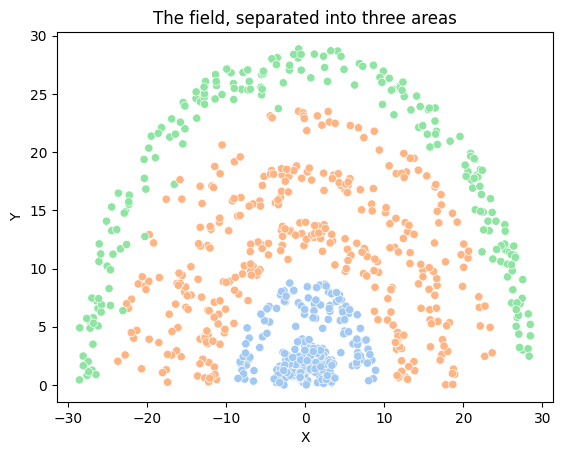

In [10]:
# make a new variable with three bins
df['RANGE_region'] = np.select(
    [
        df.RANGE_num > 23.9, 
        df.RANGE_num > 9,
    ],
    [
        'Beyond 3 points line',
        'Within 3 points line',
    ],
    default='Under basket'
)

# make the variable type Ordered Category 
df['RANGE_region'] = df['RANGE_region'].astype("category").cat.reorder_categories(['Under basket', 'Within 3 points line', 'Beyond 3 points line'], ordered=True)
        
# show the three areas
sns.scatterplot(x=df.X, y=df.Y, hue=df.RANGE_region, legend=False, palette='pastel')
plt.title("The field, separated into three areas");

# validate the RANGE_region by comparing with RANGE_num
df.sample(10)


Now we can group the data by `SHOOTER` and see each player's *field goal* percentage by area. The darker the color, the higher the percentage of successful shots in that region:

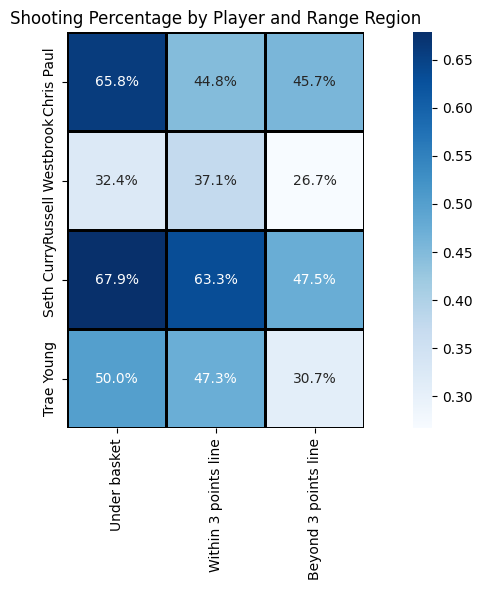

In [11]:
# Create the heatmap with proper numeric conversion
fig, ax = plt.subplots(figsize=(10, 6))

# Process and plot the data
( df
 .assign(SCORE_num=lambda x: x['SCORE'].map({'MADE': 1, 'MISSED': 0}))  # Create numeric column

.groupby(['SHOOTER', 'RANGE_region'], observed=True) .SCORE_num
 .mean()
 .unstack()
 .pipe(lambda x: sns.heatmap(x, 
                            cmap='Blues', 
                            square=True, 
                            annot=True, 
                            linecolor='Black', 
                            linewidths=1,  
                            fmt='.1%',
                            ax=ax))
)

# Customize the plot
plt.xlabel(None)
plt.ylabel(None)
plt.title('Shooting Percentage by Player and Range Region')
plt.tight_layout()

So, the best shooting position for each of the four players is as follows:
- Chris Paul, Trae Young & Seth Curry are better off shooting under the basket.
- Curry & Young are almost as efficient when shooting from the second area
- Westbrook scores better when shooting from the middle region, within the 3-point line; but his best ratio is almost half as good as Curry's.

### Who of the four players is the best defender?


The best defender is the player that blocks most of the shots made against him. Similarly to what we did above for the best shooter, we will group by the `DEFENDER` variable and calculate the ratio of *missed* shots this time, instead of *made*.

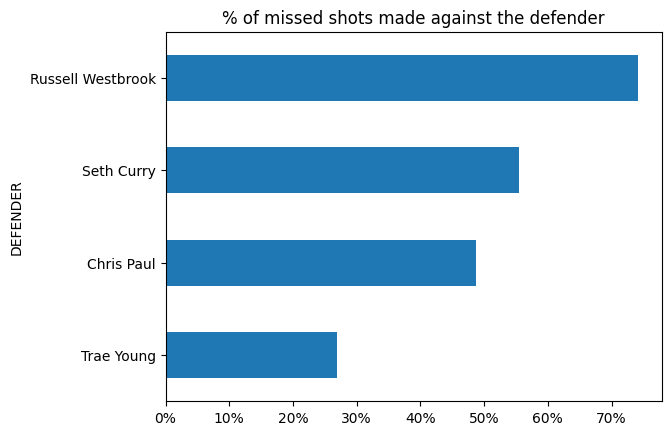

In [12]:
( df
 .replace(['MADE','MISSED'],[0,1]) #replace MADE shots with 0 and MISSED with 1
 .groupby('DEFENDER')               #group by the SHOOTER
 .SCORE                            #get only the SCORE 
 .mean()                           
 .sort_values()                   
 .plot.barh()                     
)

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title("% of missed shots made against the defender");

So, we see that **Russell Westbrook is the best defender,** as more than 70% of the shots made against him were misses.

### Is there a correlation between the efficiency of a shooter and the player who is defending him?

The efficiency of a shooter is different for each defender that comes up against him. To answer this question we have to compare the ratios of successful shots for each pair of `SHOOTER` and `DEFENDER`.

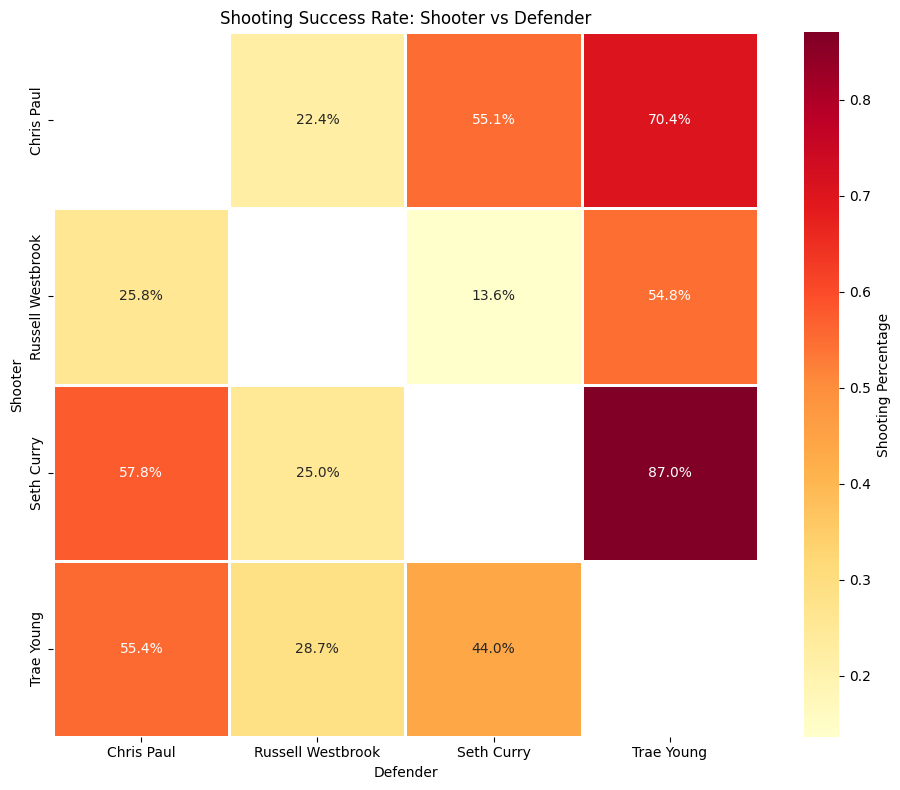

In [13]:
# Create a heatmap of shooter-defender matchups
plt.figure(figsize=(10, 8))

# Calculate the shooting percentages matrix
shooting_matrix = (df
                  .assign(SCORE_num=lambda x: x['SCORE'].map({'MADE': 1, 'MISSED': 0}))
                  .groupby(['SHOOTER', 'DEFENDER'])
                  .SCORE_num
                  .mean()
                  .unstack()
                 )

# Create the heatmap
sns.heatmap(shooting_matrix, 
            annot=True,  
            fmt='.1%',  
            cmap='YlOrRd',  
            square=True,  
            linewidths=1,
            cbar_kws={'label': 'Shooting Percentage'})

plt.title('Shooting Success Rate: Shooter vs Defender')
plt.xlabel('Defender')
plt.ylabel('Shooter')
plt.tight_layout()
plt.show()

From the table we can easily see that all players are very efficient (the darker red cells) when shooting against Trae Young, while Trae scores best when facing Chris Paul. So, the answer is **yes, there is a correleation, the efficiency of shooters is much higher when facing specific defenders.**  
Now, let's try to take this a bit further and see exactly how each pair behaves: does the shooter prefer long or close shots, and does he score the shot? For each pair, the shots will be shown according to range from basket:

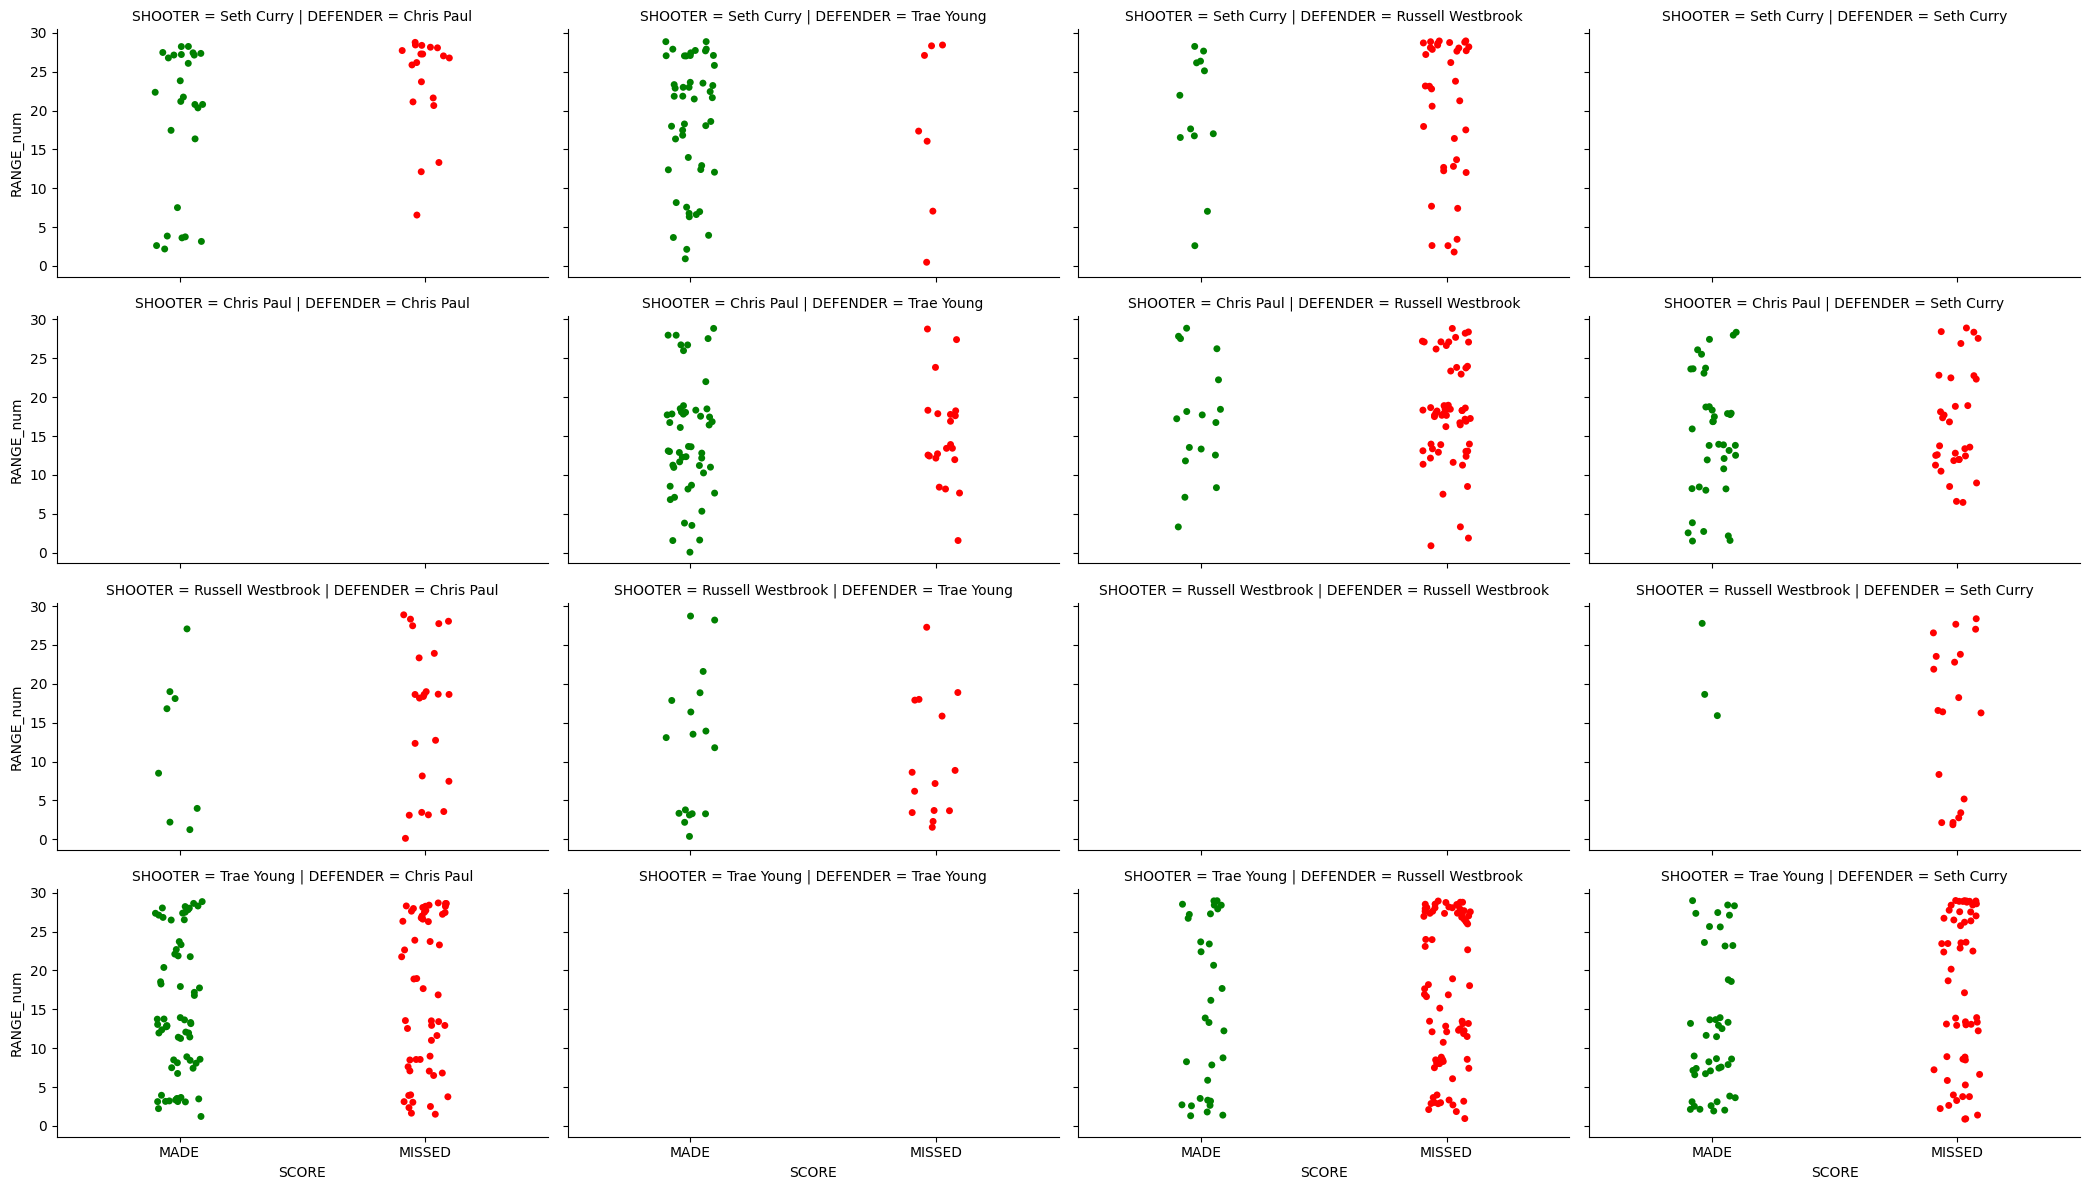

In [14]:
# Create the plot with proper hue parameter
sns.catplot(data=df,
            y='RANGE_num',
            x='SCORE',
            col='DEFENDER',
            row='SHOOTER',
            kind='strip',
            hue='SCORE',  # Add hue parameter to control colors
            palette=['green', 'red'],
            legend=False,  # Hide legend since SCORE is already on x-axis
            aspect=1.75,
            height=3)


first of all we can validate the results of the previous table with the shooter efficiencies: for example, it is clear that Westbrook cannot score against Curry and his efficiency was 13.6% in the table. What other insights do we get?
* When Curry faces Paul he prefers to shoot from long range, there are very few shots below 15 feet
* Westbrook defends very well against Young in rong range (there are many missed dots in the upper area of their plot)
* Against Paul, Westbrook is better at defending in middle ranges (the missed dots are in the middle)
* Curry does not defend at all against Paul at close ranges, below 8 feet
* It's better for Westbrook to not try shooting when facing Paul, as he will mostly likely miss the shot

## Predict the outcome of a shot
Can we train a model to predict if a shot will be `MADE` or `MISSED`? Let's try with several models and find the one that predicts with better accuracy. This is a classification problem, so let's see if the outcome classes `MADE` and `MISSED` are balanced:

In [15]:
# Is the outcome balanced or not?
df.SCORE.value_counts(normalize=True)

SCORE
MISSED    0.536082
MADE      0.463918
Name: proportion, dtype: float64

Since the outcomes are balanced (54%:46%) we can prepare the data set for training. We will use the two numeric features: `X`, `Y`. We don't need the `RANGE_region` and `RANGE_num` features since we have the `RANGE`, and testing showed that it is much more informative. We will also use the `SHOOTER` and `DEFENDER` for training by binary-encoding the player names. The ground truth will be the `SCORE` replaced with 0's for `MISSED`  and 1's for `MADE`.

The distribution of `X` is normal and `Y` is normal-like, since there is no negative values.

<Axes: ylabel='Count'>

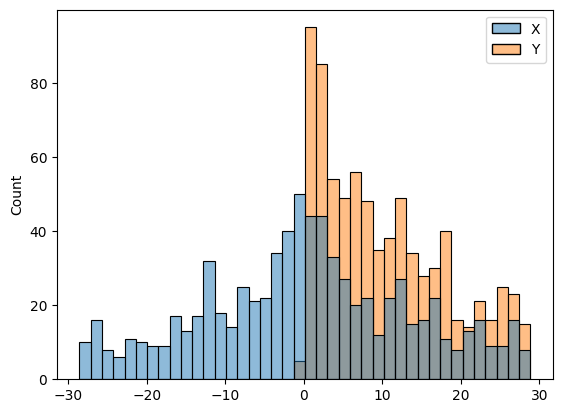

In [16]:
sns.histplot(df[['X','Y']], bins=40,alpha=.5)

So, let's construct the X and y sets for the process of training & validating a model (not to be confused with `X` and `Y` variables that are the coordinates of the shoot). The sets are then split into `train` and `test` sets, for training an dvalidating respectively. A *ColumnTransformer* will be used to preprocess the data: the numerical features will be scaled with *MinMaxScaler* and the categorical will be one-hot encoded. This transformer will be used in a pipeline later.

#### Is the data seperable?
We can inspect the set to see if there are obvious clusters and how separable the data is. The data dimensions will be reduced  with the t-SNE algorithm to two features and visualized in a scatter plot.


In [17]:
NUMERIC = ['X', 'Y', ]
CATEGORICAL = ['SHOOTER','DEFENDER', 'RANGE']

X = df[NUMERIC + CATEGORICAL]
y = df['SCORE'].replace(['MADE','MISSED'],[1,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

preprocess = ColumnTransformer( transformers=[
    ('onehot',OneHotEncoder(), CATEGORICAL),
    ('scale', MinMaxScaler(), NUMERIC),
])

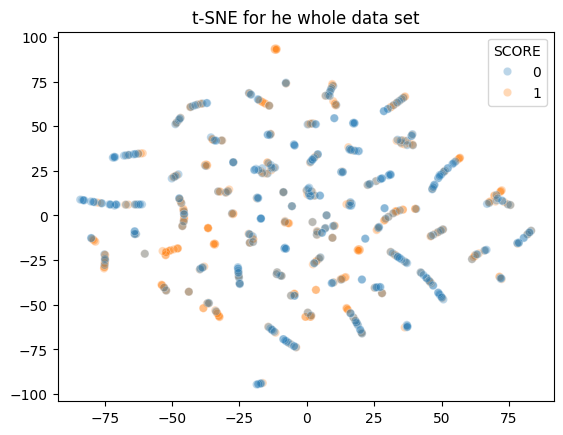

In [18]:
from sklearn.manifold import TSNE
# create the processesed dataset
X_proc = preprocess.fit_transform(X)
tsne = TSNE(n_components=2, perplexity=5).fit_transform(X_proc)

sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=y, alpha=.3)
plt.title("t-SNE for he whole data set");


The visualization shows that the dataset is not linearly separable, so classification is difficult to achieve. In this case the dataset can be projected to a higher dimension, which might be more convenient for classification. We can use *PolynomialFeatures* transformer to do this. 

#### Setting up the pipelines
Pipelines will be set up for each model we will try: Random Forest and SVC are good models for binary classification, Logistic Regression is included for benchmarking and a Multi-Level Perceptron (MLP), too

In [19]:
#polynomial transformer
polynomial = PolynomialFeatures(2, interaction_only=False, )
#set up pipelines with preprocessing, polynomial transformation & estimators
pipelines = {
    'lr' : make_pipeline(preprocess, polynomial, LogisticRegression()),
    'rf' : make_pipeline(preprocess, polynomial, RandomForestClassifier()),
    'svc': make_pipeline(preprocess, polynomial, SVC()),
    'mlp': make_pipeline(preprocess, polynomial, MLPClassifier(max_iter=1000))
}

#### Evaluating the simple models
The *roc-curve* shows how well the model performs: The more area under the curve, the better the model. We can plot the curve for each of the four models we trained, and show its *accuracy* (ACC) and *Area-Under-the-Curve* (AUC). The visual shows that ***svc* is the best of the naive models**, with the highest AUC and ACC.

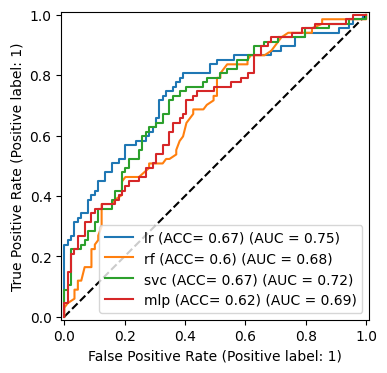

In [20]:
# Ensure target variable is properly encoded for classification
y = (df['SCORE'] == 'MADE').astype(int)  # Convert to binary: 1 for MADE, 0 for MISSED

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create ROC curve plot
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot([0, 1], [0, 1], linestyle='--', c='black')
for name, estimator in pipelines.items():
    y_pred = estimator.fit(X_train, y_train).predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    RocCurveDisplay.from_estimator(estimator, X_test, y_test, name="{} (ACC= {:.2})".format(name,acc), ax=ax)

#### Hyperparameter fine-tuning
Now that we have an idea of the bare minimum of model performance we can perform a Grid Search to fine-tune the hyperparameters of each model. The score we want to maximize is *accuracy*.

In [21]:

preprocess = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), CATEGORICAL),
    ('scale', MinMaxScaler(), NUMERIC),
])

# Polynomial transformer
polynomial = PolynomialFeatures(2, interaction_only=False)

# Set up pipelines with preprocessing, polynomial transformation & estimators
pipelines = {
    'lr': make_pipeline(
        preprocess, 
        polynomial, 
        LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000)
    ),
    'rf': make_pipeline(
        preprocess, 
        polynomial, 
        RandomForestClassifier(random_state=42)
    ),
    'svc': make_pipeline(
        preprocess, 
        polynomial, 
        SVC(probability=True, random_state=42)
    ),
    'mlp': make_pipeline(
        preprocess, 
        polynomial, 
        MLPClassifier(random_state=42, max_iter=1000)
    )
}

# Define hyperparameter grids
param_grid = {
    'lr': {
        'logisticregression__C': [0.001, 0.01, 0.1, 1.0],
        'logisticregression__tol': [0.0001, 0.001, 0.01],
    },
    'rf': {
        'randomforestclassifier__n_estimators': [100, 200],
        'randomforestclassifier__max_depth': [3, 5],
        'randomforestclassifier__min_samples_leaf': [3, 5]
    },
    'svc': {
        'svc__C': [0.1, 0.8, 1.0],
        'svc__kernel': ['linear', 'rbf'],
        'svc__tol': [0.001, 0.01, 0.03]
    },
    'mlp': {
        'mlpclassifier__hidden_layer_sizes': [(100,), (100,50)],
        'mlpclassifier__alpha': [0.0001, 0.001],
        'mlpclassifier__learning_rate': ['constant', 'adaptive']
    }
}



In [22]:
# Fit models with grid search
fitted_models = {}
for name, estimator in pipelines.items():
    print("fitting model:", name, "...")
    model = GridSearchCV(
        estimator,
        param_grid=param_grid[name],
        cv=3,
        scoring='accuracy',
        verbose=0,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    fitted_models[name] = model

fitting model: lr ...
fitting model: rf ...
fitting model: svc ...
fitting model: mlp ...


In [23]:
# grid search with linear parameters
svc_hyperparameters_linear = {    
    'svc__kernel' : [ 'linear'],
    'svc__C': [ 0.8, 0.9, 1, 1.05, 1.1, 1.15, 1.2, 1.25],
    'svc__tol':[0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
    'svc__shrinking':[True, False],
}

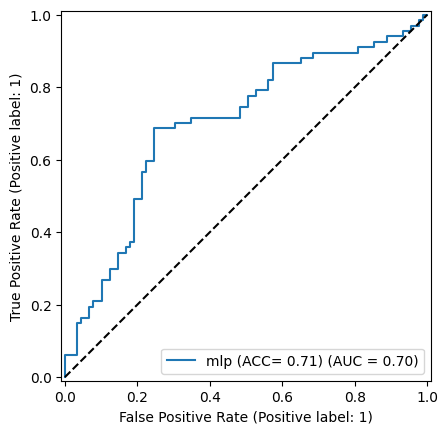

In [24]:
linear_svc_pipe = make_pipeline(preprocess, polynomial, SVC(probability=True))
linear_svc_grid = GridSearchCV(estimator=linear_svc_pipe, 
                               param_grid=svc_hyperparameters_linear, 
                               cv=5, 
                               scoring='roc_auc', 
                               verbose =0, 
                               n_jobs=-1)

linear_svc_grid.fit(X_train, y_train)
linear_svc_acc=accuracy_score(y_test, linear_svc_grid.predict(X_test))
RocCurveDisplay.from_estimator(linear_svc_grid, X_test, y_test, name="{} (ACC= {:.2})".format(name,linear_svc_acc),)
plt.plot([0, 1], [0, 1], linestyle='--', c='black');

#### Best Hyperparams
OK, further tests showed that the efficiency of the model cannot be further improved beyond ACC=0.71 and AUC=0.70, so that is the model we settle for. Let's see the best hyperparameters as found by the grid search:

In [25]:
best_params = linear_svc_grid.best_params_
print(best_params)

{'svc__C': 0.8, 'svc__kernel': 'linear', 'svc__shrinking': True, 'svc__tol': 0.03}


### The best model for predicting a successful shot:


In [26]:
best_model = make_pipeline(
    preprocess,
    polynomial,
    SVC(C=0.8, kernel='linear', shrinking=True, tol=0.03)
)

## APPENDIX
#### Probabilities Calibration
As a final step, we can examine the probabilities produced by the chosen model. 

Instead of simply predicting a `0` for a missed shot and `1` for a made shot, the model can give us the probability a shot is successful. Let's see the distribution of the probabilities for the *test* set:

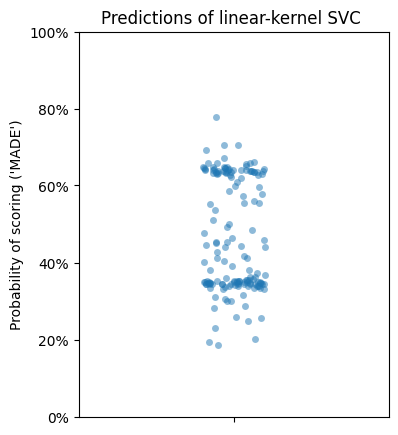

In [27]:
#get the probabilities of scoring a shot
y_proba = linear_svc_grid.predict_proba(X_test)[:,1]
#plot the probabilities
plt.figure(figsize=(4,5))
sns.stripplot(y=y_proba,alpha=.5)
plt.ylim(0,1)
plt.ylabel("Probability of scoring ('MADE')")
plt.title("Predictions of linear-kernel SVC ")
#format the y-axis
import matplotlib.ticker as mtick 
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1));

We see that the model is not very confident of predicting either a mode or a missed shot. This is a characteristic for SVC models: the probabilities tend to gather at the grey area, in our case between 30% and 70%, with greater densities at ~40% and ~60%. A calibration curve might give more insights about this:

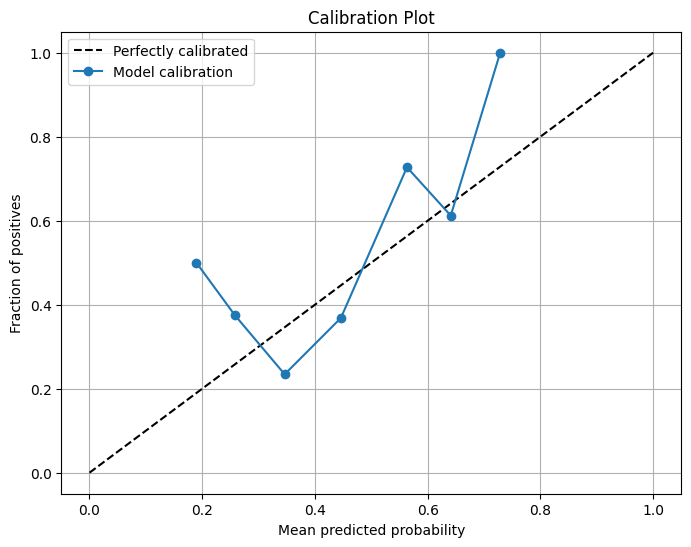

In [28]:
# Create calibration plot
plt.figure(figsize=(8, 6))
fop, mpv = calibration_curve(y_test, y_proba, n_bins=10)

# Plot perfectly calibrated line
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
plt.plot(mpv, fop, marker='o', label='Model calibration')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True)
plt.show()

Now, lets calibrate the model and check for improvements. We can compare the new curve (after calibration) and see if it is getting nearer the black line of a pefect calibration. 

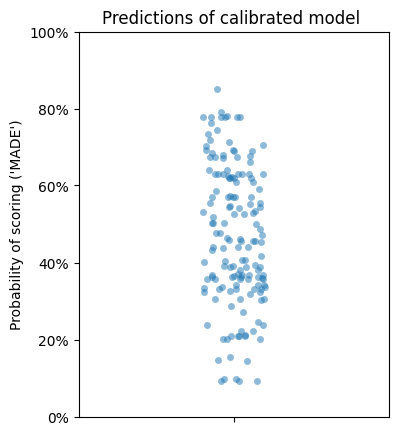

In [29]:

# fit a model with the best hyperparameters
best_model = SVC(C= 0.8, kernel='linear', shrinking=True, tol=0.03)

# make a pipeline for calibration and fit the model for calibration
calibrated = make_pipeline(preprocess, polynomial, CalibratedClassifierCV(best_model, method='isotonic', cv=5))
calibrated.fit(X_train, y_train)
# predict probabilities
calibrated_probs = calibrated.predict_proba(X_test)[:, 1]

plt.figure(figsize=(4,5))
sns.stripplot(y=calibrated_probs,alpha=.5)
plt.ylim(0,1)
plt.ylabel("Probability of scoring ('MADE')")
plt.title("Predictions of calibrated model ")
#format the y-axis
import matplotlib.ticker as mtick 
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1));

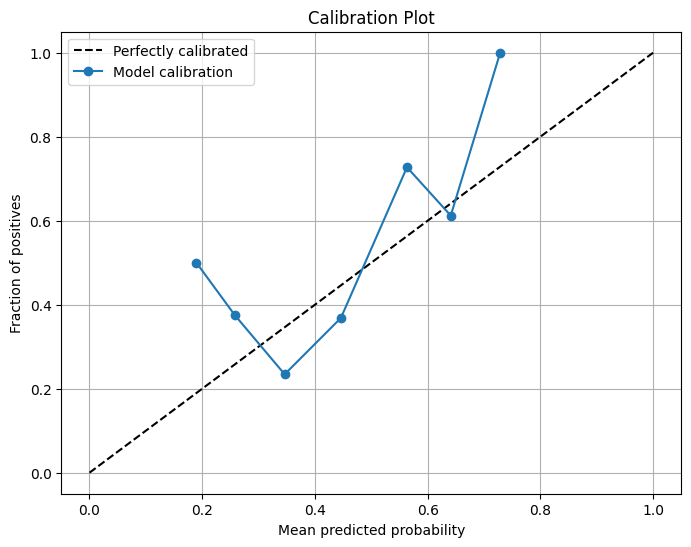

In [30]:
# Create calibration plot
plt.figure(figsize=(8, 6))
fop, mpv = calibration_curve(y_test, y_proba, n_bins=10)

# Plot perfectly calibrated line
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
plt.plot(mpv, fop, marker='o', label='Model calibration')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True)
plt.show()

As shown in the plot, the probabilities now are more spread out than before, also the curve now fits better to the perfect calibration line. But, if we check the scores for accuracy and auc, we see that they are worse than before:

In [31]:
print("Uncalibrated model - Accuracy {:.2}, AUC {:.2}".format(
    accuracy_score(y_test, y_proba>0.5), roc_auc_score(y_test, y_proba)))
print("  Calibrated model - Accuracy {:.2}, AUC {:.2}".format(
    accuracy_score(y_test, calibrated_probs>0.5), roc_auc_score(y_test, calibrated_probs)))

Uncalibrated model - Accuracy 0.69, AUC 0.7
  Calibrated model - Accuracy 0.66, AUC 0.71


*I don’t see any way to improve this model further, so I’ll conclude it here.*